In [2]:
import numpy as np
import librosa,librosa.display
import matplotlib.pyplot as plt
import os
import math
import json
from sklearn.model_selection import train_test_split
import random
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import tensorflow.keras as keras
import keras_tuner as kt

In [3]:
def plot_history(history):
    fig,axs = plt.subplots(2)
    
    #create accuracy subplot
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy eval")
    axs[0].legend(loc="lower right")
    
    #create error subplot
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Error eval")
    axs[1].legend(loc="upper right")
    
    plt.show()

In [4]:
#path to json
DATA_PATH="C:/Users/adithi/Downloads/final_project-main/DATA_10.json"

In [5]:
def load_data(data_path):
    
    with open(data_path,"r") as f:
        data=json.load(f)
        
    #convert list to nympy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    print("data successfully loaded")
    
    return X,y

In [6]:
#load data
X,y=load_data(DATA_PATH)

data successfully loaded


In [7]:
X.shape

(6705, 130, 13)

In [12]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [13]:
X_train.shape

(5028, 130, 13)

In [14]:
nsamples, nx, ny = X_train.shape
d2_X_train = X_train.reshape((nsamples,nx*ny))

msamples, mx, my = X_test.shape
d2_X_test = X_test.reshape((msamples,mx*my))

In [15]:
input_shape=(X_train.shape[1],X_train.shape[2],1)

# Avoid overfitting

In [16]:
#build network topology
model_regulrized = keras.Sequential([
    
    #input layer
    keras.layers.Flatten(input_shape=(X.shape[1],X.shape[2])),
    
    #1st dense layer
    keras.layers.Dense(512,activation ='relu',kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5), #power off 30%
    
    #2nd dense layer
    keras.layers.Dense(256,activation ='relu',kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    
    #3rd dense layer
    keras.layers.Dense(64,activation ='relu',kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    
    #output layer
    keras.layers.Dense(11,activation = 'softmax') #10 genres
    
])

In [17]:
#compile mode
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_regulrized.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [43]:
#train model
history = model_regulrized.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=100)

Epoch 1/100
126/126 [==============================] - 4s 34ms/step - loss: 1.4320 - accuracy: 0.5450 - val_loss: 1.5520 - val_accuracy: 0.5754
Epoch 2/100
126/126 [==============================] - 4s 31ms/step - loss: 1.4185 - accuracy: 0.5540 - val_loss: 1.5665 - val_accuracy: 0.5701
Epoch 3/100
126/126 [==============================] - 4s 33ms/step - loss: 1.4403 - accuracy: 0.5482 - val_loss: 1.6009 - val_accuracy: 0.5486
Epoch 4/100
126/126 [==============================] - 4s 33ms/step - loss: 1.4447 - accuracy: 0.5395 - val_loss: 1.5712 - val_accuracy: 0.5671
Epoch 5/100
126/126 [==============================] - 4s 32ms/step - loss: 1.4044 - accuracy: 0.5433 - val_loss: 1.5407 - val_accuracy: 0.5534
Epoch 6/100
126/126 [==============================] - 4s 33ms/step - loss: 1.4264 - accuracy: 0.5522 - val_loss: 1.5899 - val_accuracy: 0.5474
Epoch 7/100
126/126 [==============================] - 4s 32ms/step - loss: 1.4423 - accuracy: 0.5361 - val_loss: 1.5660 - val_accuracy:

In [33]:
# evaluate model on Test Set
test_loss, test_acc = model_regulrized.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

53/53 - 0s - loss: 1.4926 - accuracy: 0.6297

Test accuracy: 0.6296958923339844


# CNN Model

In [46]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [47]:
X_train.shape

(4022, 130, 13, 1)

In [48]:
input_shape=(X_train.shape[1],X_train.shape[2],1)

In [49]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape)) #32 is num of filters,(3,3) convolutional mask dimension
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.8))

# output layer
model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [50]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 64)       640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 64)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 64)         256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 128)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 128)        512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 1, 64)        

In [52]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

Epoch 1/100
126/126 [==============================] - 28s 222ms/step - loss: 4.0964 - accuracy: 0.1134 - val_loss: 2.4147 - val_accuracy: 0.1431
Epoch 2/100
126/126 [==============================] - 28s 220ms/step - loss: 3.3860 - accuracy: 0.1442 - val_loss: 2.2116 - val_accuracy: 0.2376
Epoch 3/100
126/126 [==============================] - 28s 220ms/step - loss: 3.0700 - accuracy: 0.1691 - val_loss: 2.2076 - val_accuracy: 0.2416
Epoch 4/100
126/126 [==============================] - 28s 222ms/step - loss: 2.8780 - accuracy: 0.1668 - val_loss: 2.1256 - val_accuracy: 0.2803
Epoch 5/100
126/126 [==============================] - 28s 224ms/step - loss: 2.6755 - accuracy: 0.1967 - val_loss: 2.0718 - val_accuracy: 0.3201
Epoch 6/100
126/126 [==============================] - 28s 224ms/step - loss: 2.6192 - accuracy: 0.1825 - val_loss: 2.0521 - val_accuracy: 0.3012
Epoch 7/100
126/126 [==============================] - 29s 231ms/step - loss: 2.4806 - accuracy: 0.2096 - val_loss: 2.0152 -

In [54]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

53/53 - 3s - loss: 1.2758 - accuracy: 0.5963

Test accuracy: 0.5963029265403748


In [53]:
# evaluate model on Test Set
test_loss, test_acc = model_regulrized.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

53/53 - 0s - loss: 1.1720 - accuracy: 0.6881

Test accuracy: 0.6881335973739624


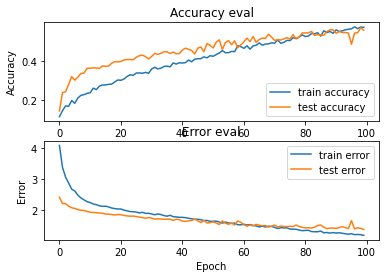

In [55]:
plot_history(history)

In [56]:
# pick a sample to predict from the test set
X_to_predict = X_test[420]
y_to_predict = y_test[420]

In [57]:
X_to_predict.shape

(130, 13, 1)

In [58]:
print("Real Instrument:", y_to_predict)

Real Instrument: 0


In [59]:
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [60]:
X_to_predict.shape

(1, 130, 13, 1)

In [61]:
#perform prediction
prediction = model_regulrized.predict(X_to_predict)

In [62]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Instrument:", int(predicted_index))

Predicted Instrument: 0


In [63]:
# pick a sample to predict from the test set
X_to_predict = X_test[25]
y_to_predict = y_test[25]

print("Real Instrument:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Instrument:", int(predicted_index))

Real Instrument: 7
Predicted Instrument: 7


In [64]:
len(X_test)

1677

In [91]:
for n in range(10):
    
    
    i=random.randint(0,len(X_test))
    # pick a sample to predict from the test set
    X_to_predict = X_test[i]
    y_to_predict = y_test[i]

    print("\nReal Instrument:", y_to_predict)

    X_to_predict = X_to_predict[np.newaxis, ...]

    prediction = model_cnn.predict(X_to_predict)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Predicted Instrument:", int(predicted_index))


Real Instrument: 4
Predicted Instrument: 4

Real Instrument: 1
Predicted Instrument: 1

Real Instrument: 4
Predicted Instrument: 4

Real Instrument: 2
Predicted Instrument: 2

Real Instrument: 0
Predicted Instrument: 4

Real Instrument: 8
Predicted Instrument: 7

Real Instrument: 8
Predicted Instrument: 8

Real Instrument: 3
Predicted Instrument: 3

Real Instrument: 6
Predicted Instrument: 6

Real Instrument: 5
Predicted Instrument: 5


# Prediction on new songs

In [68]:
# Audio files pre-processing
def process_input(audio_file, track_duration):
    
    SAMPLE_RATE = 22050
    NUM_MFCC = 13
    N_FTT=2048
    HOP_LENGTH=512
    TRACK_DURATION = track_duration # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    NUM_SEGMENTS = 10

    samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

    signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
    for d in range(10):
        
        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
        mfcc = mfcc.T

        return mfcc

In [69]:
instrument_dict = {0:"cello",1:"cla",2:"flu",3:"gac",4:"gel",5:"org",6:"pia",7:"sax",8:"tru",9:"vio",10:"voi"}

In [78]:
new_input_mfcc = process_input("(02) dont kill the whale-1.wav", 30)

In [79]:
type(new_input_mfcc)

numpy.ndarray

In [80]:
new_input_mfcc.shape

(130, 13)

In [81]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [83]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Instrument:", instrument_dict[int(predicted_index)])

Predicted Instrument: gel


In [84]:
new_input_mfcc = process_input("(02) dont kill the whale-6.wav", 30)

In [85]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [89]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Instrument:", instrument_dict[int(predicted_index)])

Predicted Instrument: org
